In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils, plot_help


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_curve, roc_auc_score, precision_recall_curve

from joblib import dump, load

%matplotlib inline

In [2]:
df = utils.chunk_loader('data/cleaned/business_merge_feats.csv', read_limit=-1)


df = df.drop(columns=['latitude', 'longitude', 'postal_code'])

#select only numerical columns
df_num = df.select_dtypes(include=['int', 'float64'])
df_num.shape

df_num.head()

,review_count,stars,road_type,GoodForKids,RestaurantsReservations,Caters,RestaurantsTableService,RestaurantsTakeOut,RestaurantsPriceRange2,OutdoorSeating,...,Health,Hair,cool_change,funny_change,stars_change,useful,avg_month_checkin,span_checkin,median_income,is_open
0,5,3.0,1.0,0,0,0,0,0,0,0,...,0,0,0.000000,0.00000,0.000000,0.000000,1.777778,5323,3.5,0
1,128,2.5,8.0,1,1,1,1,1,2,0,...,0,0,-0.042484,-0.04902,-0.075163,-0.156863,36.083333,15143,3.0,1
2,170,4.0,6.0,1,1,0,1,1,2,0,...,0,0,-0.110000,-0.19000,0.055000,-0.215000,57.083333,58518,3.5,1
3,3,5.0,1.0,0,0,0,0,0,0,0,...,0,0,0.000000,0.00000,0.000000,-0.500000,1.222222,8464,3.5,1
4,3,2.5,6.0,0,0,0,0,0,2,0,...,0,0,0.000000,0.00000,0.000000,0.000000,1.000000,2971,3.0,1


## From L1 penalty drop columns that had 0 coefficients

#### Note: We moved is_open feature to last position in dataframe to be able to copy column indeces as is

In [3]:
drop_col_loc = [25, 26, 27, 50, 62, 69, 70, 72, 73, 74, 75, 76, 88, 98]

df_num = df_num.drop(df_num.columns[drop_col_loc], axis=1)

In [4]:
df_num.shape

(161160, 88)

In [5]:
X_train, X_test, y_train, y_test = utils.train_test_scale (df_num, 
                                                           'is_open', 
                                                           random_state=None)

/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:
#instantiate logistic regression
lr = LogisticRegression(max_iter=200)

#param grid
lr_param = {'penalty': ['l1', 'l2'], 
            'C': np.power(10.0, np.arange(-4, 4)), 
            'solver': ['liblinear'], 
            'class_weight' :['balanced', None]}

#instantite grid search
lr_cv = GridSearchCV(lr, lr_param, cv=5, n_jobs=-1, scoring='roc_auc', verbose=10)
#fit to training data
lr_cv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 60.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed: 139.2min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 213.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 270.8min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed: 855.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'solver': ['liblinear'], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [7]:
#see best combo
print(lr_cv.best_params_ )

print(lr_cv.best_score_)

{'C': 1000.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
0.7422376918392182


              precision    recall  f1-score   support

           0       0.36      0.63      0.45      6072
           1       0.90      0.74      0.81     26160

   micro avg       0.72      0.72      0.72     32232
   macro avg       0.63      0.68      0.63     32232
weighted avg       0.79      0.72      0.74     32232

--------------------------------------------------
Normalized confusion matrix


/Users/nadimkawwa/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


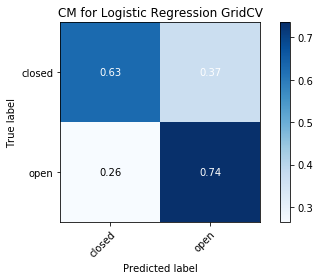

--------------------------------------------------


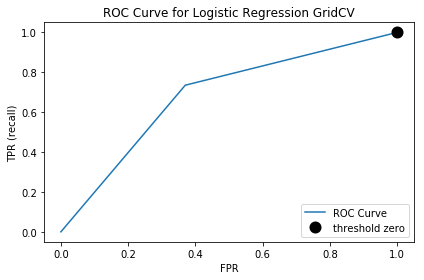

Area Under Curve = 0.6827
--------------------------------------------------


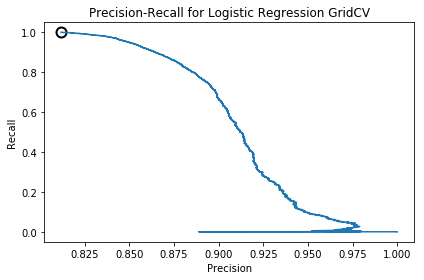

In [8]:
#make pred
y_lr = lr_cv.predict(X_test)

print(classification_report(y_test, y_lr))
print(50*'-')
plot_help.plot_confusion_matrix(y_test, y_lr, ['closed', 'open'], normalize=True,
                                title='Logistic Regression GridCV')
print(50*'-')
plot_help.plot_roc_curve(y_test, y_lr, 'Logistic Regression GridCV')
print(50*'-')
plot_help.plot_prc_curve(y_test, lr_cv.predict_proba(X_test)[:, 1], 'Logistic Regression GridCV')